**Machine Learning Development life cycle**  
1. Task  
2. Data Preparation  
3. Modelling
4. Error Measurement
5. Training and Optimization
6. Performance Measurement
7. Validating and Testing
8. Corrective Measures

Using Python 3.8.18

In [303]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds 
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, InputLayer, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers.legacy import Adam

**Data Preparation**

![Dataset split](Dataset_Split.png "Dataset split")  
The split of this dataset is only "Train", so we can't have "Test"

In [304]:
dataset, dataset_info = tfds.load("malaria", with_info = True, shuffle_files=True, as_supervised=True, split=["train"])

In [305]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [306]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/Users/cheesemac/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin bl

In [307]:
for data in dataset[0].take(5):
    print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(121, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [308]:
print(len(dataset[0]))

27558


Now we define a `splits()` function to split our dataset into train, validation and test sets with given ratios, using `take()` and `skip()`

In [309]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(DATASET_SIZE*TRAIN_RATIO))

    val_dataset = dataset.skip(int(DATASET_SIZE*TRAIN_RATIO))
    val_dataset = val_dataset.take(int(DATASET_SIZE*VAL_RATIO))

    test_dataset = dataset.skip(int(DATASET_SIZE*(TRAIN_RATIO + VAL_RATIO)))

    return train_dataset, val_dataset, test_dataset

Looking at the picture about the splits of this dataset, we should note that this dataset is of type `list`, in order to access the data, we have to go to index `0`, so `dataset[0]`

In [310]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 1 - (TRAIN_RATIO + VAL_RATIO)

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

22046
2755
2756


In [311]:
print(list(val_dataset.take(5).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1), (array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
      

In [312]:
for data in val_dataset.take(16):
    print(data)

(<tf.Tensor: shape=(133, 136, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(121, 151, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

**Dataset Visualization**

In [313]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/Users/cheesemac/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin bl

Looking at `"label"`, we can see that it is of `ClassLabel()` feature, with `num_classes = 2` meaning that it contains 2 classes. Labels are stored as integers in the dataset. When you retrieve the labels, `ClassLabel.int2str()` and `ClassLabel.str2int()` carries out the conversion from integer value to label name, and vice versa.  

There is also `Value()` feature.

*Referenced from:* https://huggingface.co/docs/datasets/about_dataset_features

Using `plt.subplot`

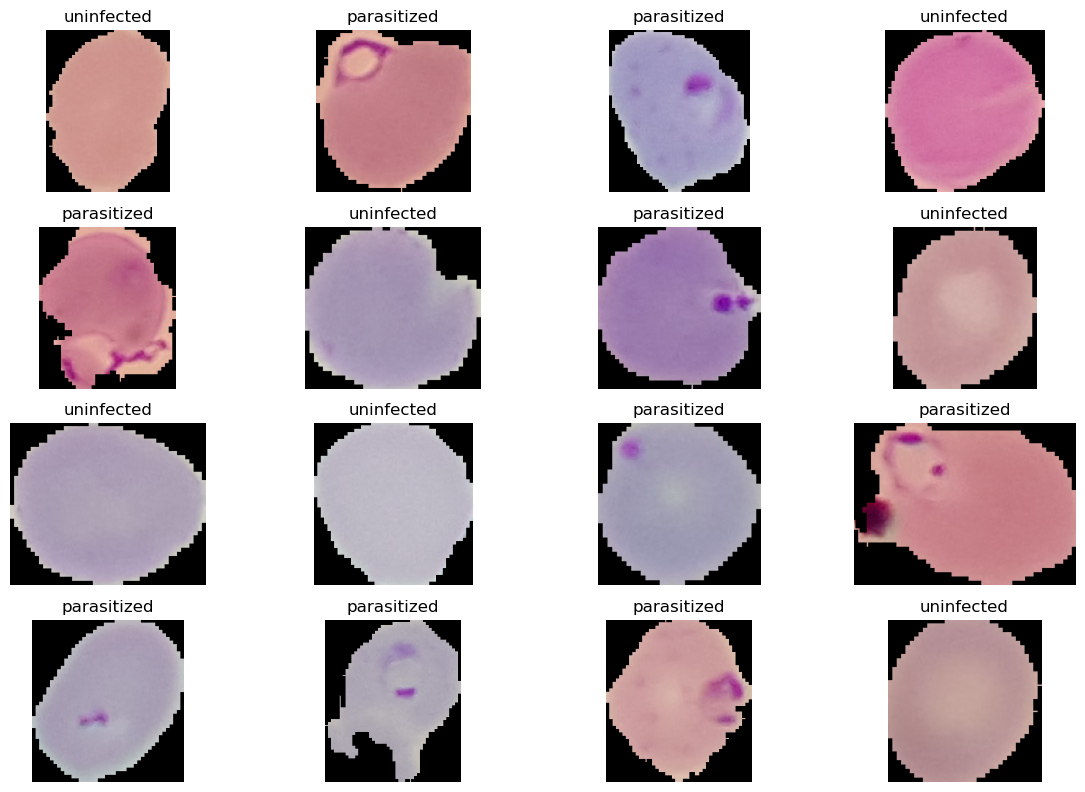

In [314]:
plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(train_dataset.take(16)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis("off")

plt.tight_layout(pad=1)

**Data Processing**

When do we use stadardization, and when normalization?  
* We use standardization when the data in our dataset lie mainly around a mean with standard deviation.
* We use normalization when the data in our dataset are mainly different and is distributed fairly randomly within a range (min, max)

That explains why normalization is a better suit for this dataset, since the values lie between 0 and 255 and are faily random. In this case, our normalization formula is going to be `(x - x_min)/(x_max - x_min) = x / 255`

First, we need to resize our images to have an uniform size

We will use `map()` attribute to apply a resizing function to our dataset. But since this attribute only return our image and not our label, which is also needed to assign to our dataset, we will first define a resizing function

In [315]:
IMG_SIZE = 224
def resize_normalize(img, label):
    return tf.image.resize(img, [IMG_SIZE, IMG_SIZE]) / 255, label

In [316]:
train_dataset = train_dataset.map(resize_normalize)
val_dataset = val_dataset.map(resize_normalize)
test_dataset = test_dataset.map(resize_normalize)

In [317]:
for image, label in val_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)


The data type of `resize_normalize(img, label)[0]` is kind of like a list or an array, that's why we can broadcast like `tf.image.resize(img, [IMG_SIZE, IMG_SIZE]) / 255` in the function `resize_normalize`

In [318]:
for img, label in train_dataset.take(1):
    print(list(resize_normalize(img, label)[0]))

[<tf.Tensor: shape=(224, 3), dtype=float32, numpy=
array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
    

In [319]:
BUFFER_SIZE = 300
BATCH_SIZE = 200
train_dataset = train_dataset.shuffle(buffer_size= BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size= BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

**Convolutional Neural Network (CNN)**  
For better visualization: https://poloclub.github.io/cnn-explainer/  
Note for padding: When using padding, we have to ensure that the outer layers (especially the corners) still have impact on the data

Padding is especially useful when the actual image is located somewhere in the outer layer. When padding, the cursor with given kernel size will go through the image more times.  

`output = (input + 2 * Padding - Kernel)/Stride + 1`


***How CNN works:***  

 ![CNN Visualization](CNN.png "CNN Visualization")  

 With the kernel, padding and stride specified, the kernel will now parse through the input of all dimensions, multiply by a *filter* and take the sum of all the results to be the output value at the corresponding position.  

 The filter is a matrix of the same size with the kernel. There are pre-existing filters like outline, sharpen or blur etc.  
 
 ![Outline filter](Filter.png "Outline filter")  
 Visual source: https://setosa.io/ev/image-kernels/
 
 But in CNN, we don't specify the filter. We just initialize the initial filter matrix, and let the model decide for themselves.  

***LeNet and AlexNet***  

![LeNet and AlexNet](AlexNet_Lenet.png "LeNet and AlexNet")  
Visual source: https://en.wikipedia.org/wiki/AlexNet  

Explanation on how to get outputs:  
![Output](Output.png "Output")  

If the image has size 64x64x3 (RGB), when applied to a filter 5x5 like in the illustration shown above, will have an output of shape AxAx1, in order to get something like AxAx6, we have to have 6 filters, and then stack the output on each other (into ***channels***).  

Moreover, for each filter, after multiplying the input to the filter, we have to add the bias. In total, we would have 6 biases.  

Parameters to be trained: **(3 x 5 x 5) x 6 + 6 = 456** parameters to be trained

**Pooling Layers**  

Pooling layer summarises the features present in regions of the output map generated by the CNN, and reduces the dimension of the input to the next layer  

To reduce the dimension to a half, we pick the size of filter (kernel) to be 2, and stride 2, because then `output = (input - kernel) / stride + 1 = (input - 2) / 2 + 1 = input / 2`

In [320]:
model = Sequential([
    InputLayer(input_shape = (IMG_SIZE, IMG_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 5, padding = "valid", activation = "sigmoid"),
    MaxPool2D(pool_size = 2, strides=2),

    Conv2D(filters = 16, kernel_size = 5, padding = "valid", activation = "sigmoid"),
    MaxPool2D(pool_size = 2, strides=2),

    Flatten(),

    Dense(100, activation = "sigmoid"),
    Dense(10, activation = "sigmoid"),
    Dense(1, activation = "sigmoid")
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 220, 220, 6)       456       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 110, 110, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 106, 106, 16)      2416      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 53, 53, 16)        0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 44944)             0         


                                                                 
 dense_21 (Dense)            (None, 100)               4494500   
                                                                 
 dense_22 (Dense)            (None, 10)                1010      
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                                 
Total params: 4498393 (17.16 MB)
Trainable params: 4498393 (17.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [321]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss = BinaryCrossentropy(from_logits=False))

In [322]:
# sess = tf.compat.v1.Session(config=config)
# process = model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1)

**Hint:** The fact that this error is thrown after the first epoch was thrown means that the problem probably lies in the `val_dataset`

In [323]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [324]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

We can see that we haven't yet resize our `val_dataset`. Let's go resize and normalize our `val_dataset` and try again.

In [325]:

process = model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1)

Epoch 1/100


2024-01-30 19:41:55.451250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - ETA: 0s - loss: 0.7049

2024-01-30 19:42:13.473819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 20s 172ms/step - loss: 0.7049 - val_loss: 0.6987
Epoch 2/100
111/111 [==============================] - 19s 173ms/step - loss: 0.6943 - val_loss: 0.6960
Epoch 3/100
111/111 [==============================] - 19s 172ms/step - loss: 0.6948 - val_loss: 0.6932
Epoch 4/100
111/111 [==============================] - 19s 171ms/step - loss: 0.6936 - val_loss: 0.6932
Epoch 5/100
111/111 [==============================] - 19s 172ms/step - loss: 0.6934 - val_loss: 0.6931
Epoch 6/100
111/111 [==============================] - 19s 173ms/step - loss: 0.6935 - val_loss: 0.6931
Epoch 7/100
111/111 [==============================] - 19s 173ms/step - loss: 0.6934 - val_loss: 0.6931
Epoch 8/100
111/111 [==============================] - 19s 174ms/step - loss: 0.6934 - val_loss: 0.6932
Epoch 9/100
111/111 [==============================] - 19s 174ms/step - loss: 0.6935 - val_loss: 0.6931
Epoch 10/100
111/111 [==============================] - 19s 174ms/step - los

KeyboardInterrupt: 

In [ ]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
